# Índice
1. [Introdução](#introduction)  
2. [Pré-processamento dos dados](#pre-processing)  
3. [Visualização dos dados](#data-visualization)  
 3.1. [Gráficos de correalação](#corr-graphs)  
 3.2. [Comparação dos valores de target com outras features](#target-features)  
4. [Experimentos](#experiments)  
 4.1. [Sem modificar os Hiperparâmetros](#without-using-hyperparameters)  
 4.2. [Utilizando os Hiperparâmetros](#using-hyperparameters)  
 4.3. [Utilizando somente a temperatura máxima](#using-just-max-temp)
5. [Referências](#references)

## 1. Introdução <a name="introduction"></a>
<p>Este <i>notebook</i> contém a utilização do algoritmo de regressão conhecido como [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) - Gradiente Descendente Estocástico ou do inglês <i>Stochastic Gradient Descent.</i></p>

In [54]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns; sns.set() 
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 2. Pré-processamento dos dados <a name="pre-processing"></a>
<p>Todo o passo-a-passo do pré-processamento dos dados pode ser encontrado no arquivo <i>rdu-weather-history.ipynb</i>, sendo que aqui o processo será bastante semelhante, porém de maneira reduzida e com modificações para adequar melhor à situação.</p>

In [55]:
weather_history = pd.read_csv('rdu-weather-history.csv', parse_dates=['date'], sep=';')
weather_history.shape

(4137, 28)

Substituindo as string por números binários:
* No = 0.0
* Yes = 1.0

In [56]:
weather_history = weather_history.replace('No', 0.0)
weather_history = weather_history.replace('Yes', 1.0)

<p>Esse é um caso em que o pré-processamento diverge do arquivo de pré-processamento. Isso aconteceu porque a abordagem utilizando esse modelo é diferente, não dividindo o dataset por estação do ano, e sim utilizando ele todo, mas substituindo a <i>feature season</i> por <i>dummies</i>. Essa escolha foi feita devido ao <i>SGDRegressor </i> ser mais indicado para datasets grandes, passando de 10000 linhas, por isso é mais interessante aplicá-lo em um de 4000 linhas do que em 4 de aproximadamente 1000 linhas.</p>

Substituindo os valores nulos pela média dos valores referentes a feature

In [57]:
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
weather_history[['temperaturemin']] = imputer.fit_transform(weather_history[['temperaturemin']])
weather_history[['temperaturemax']] = imputer.fit_transform(weather_history[['temperaturemax']])
weather_history[['precipitation']] = imputer.fit_transform(weather_history[['precipitation']])
weather_history[['snowfall']] = imputer.fit_transform(weather_history[['snowfall']])
weather_history[['snowdepth']] = imputer.fit_transform(weather_history[['snowdepth']])
weather_history[['avgwindspeed']] = imputer.fit_transform(weather_history[['avgwindspeed']])
weather_history[['fastest2minwinddir']] = imputer.fit_transform(weather_history[['fastest2minwinddir']])
weather_history[['fastest2minwindspeed']] = imputer.fit_transform(weather_history[['fastest2minwindspeed']])
weather_history[['fastest5secwinddir']] = imputer.fit_transform(weather_history[['fastest5secwinddir']])
weather_history[['fastest5secwindspeed']] = imputer.fit_transform(weather_history[['fastest5secwindspeed']])

Criando coluna season a partir da data

In [58]:
season_array = []
for date in weather_history['date']:
    if int(date.strftime('%m%d')) >= 1221 or int(date.strftime('%m%d')) <= 319:
        season = 'winter'
    elif int(date.strftime('%m%d')) >= 320 and int(date.strftime('%m%d')) <= 620:
        season = 'spring'
    elif int(date.strftime('%m%d')) >= 621 and int(date.strftime('%m%d')) <= 921:
        season = 'summer'
    elif int(date.strftime('%m%d')) >= 922 and int(date.strftime('%m%d')) <= 1220:
        season = 'autumn'    
    
    season_array.append(season)

weather_history = weather_history.drop(columns=['date'])
weather_history['season'] = season_array

Substituindo a coluna season por dummies

In [59]:
weather_history = weather_history
dummies = pd.get_dummies(weather_history['season'])
weather_history = weather_history.drop(columns=['season'])
dummie_weather_history = pd.concat([weather_history, dummies], axis=1)

dummie_weather_history.shape

(4137, 31)

## 3. Visualização dos dados <a name="data-visualization"></a>
<p>Assim como no pré-processamento dos dados, a visualização deles também foi feita de uma meneira um pouco diferente nesse contexto, tendo em vista que foram criadas as <i>dummies</i> e com isso o número de features aumentou.</p>

### 3.1 Gráficos de correlação <a name="corr_graphs"></a>
<p>Assim como no arquivo principal, também foi usado a biblioteca <i>Seaborn</i> para visualizações estatísticas, nesse caso com o <i>coeficiente de correlação de Pearson</i>.</p>

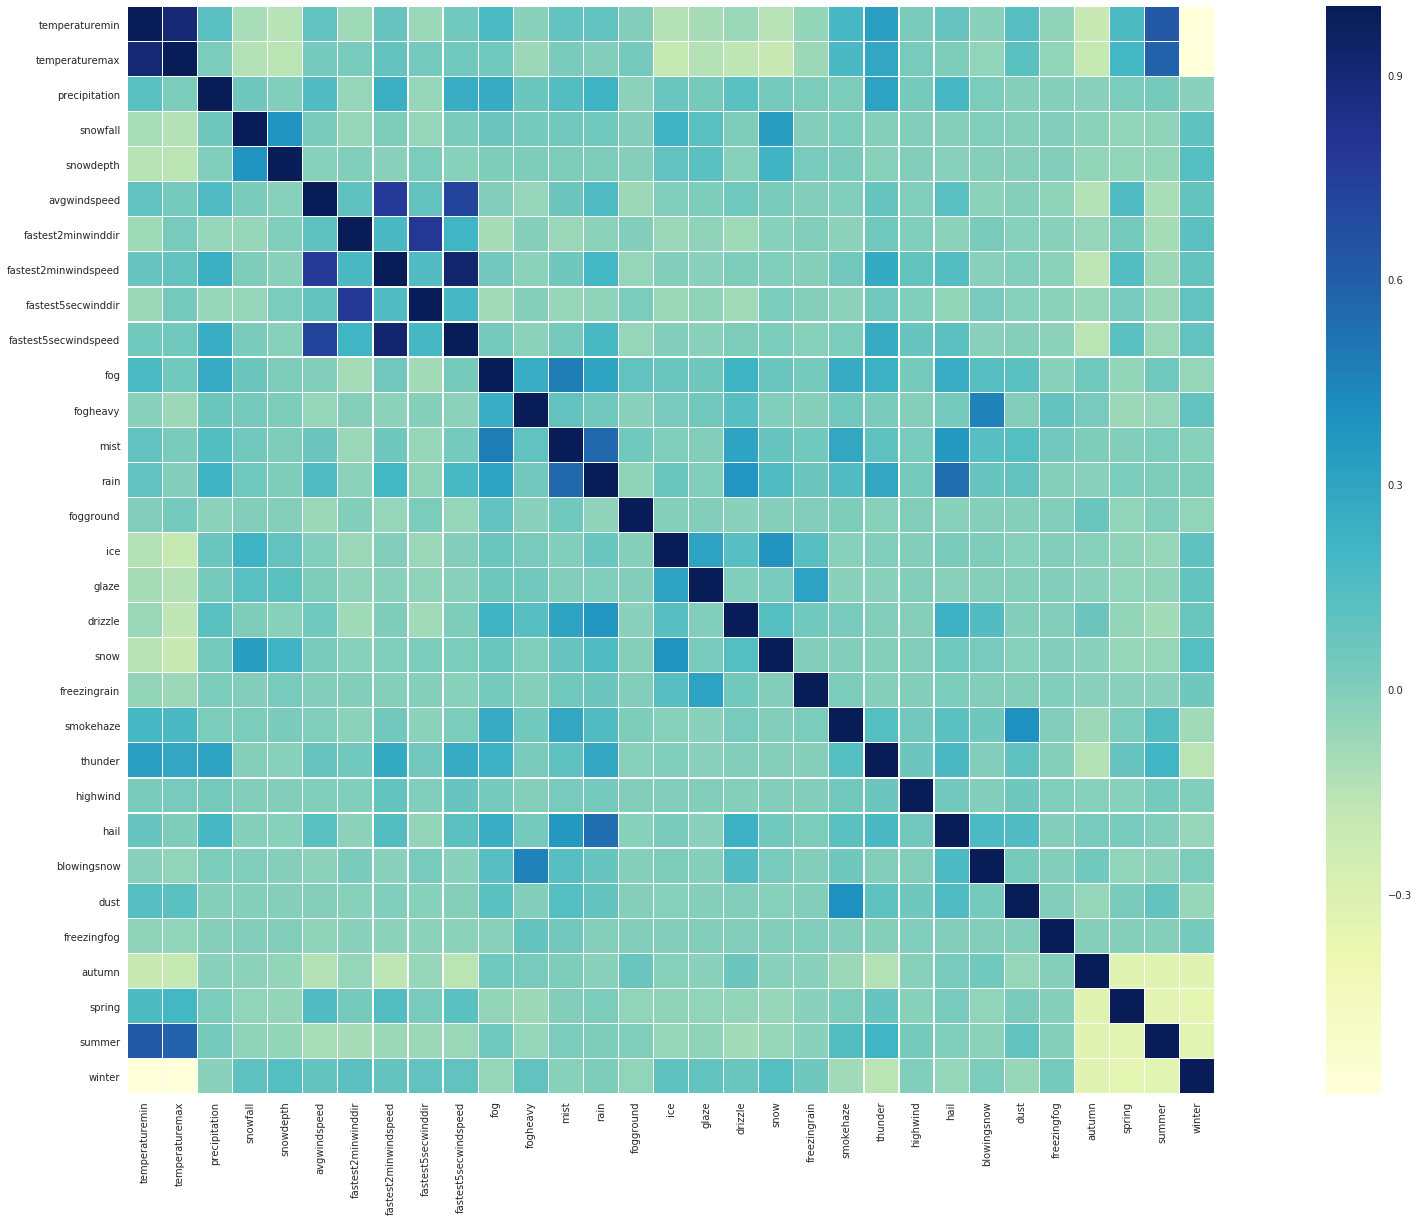

In [60]:
plt.rcParams['figure.figsize'] = [40, 20]
sns.heatmap(dummie_weather_history.corr(), square=True, cmap="YlGnBu", linewidths=.2)

Usando esse coeficiente, também foi possível plotar um gráfico da correlação das features com a feature target - *temperaturemin*, além dos valores ordenados de forma crescente.

temperaturemin          1.000000
temperaturemax          0.905429
summer                  0.628894
thunder                 0.325817
smokehaze               0.190448
fog                     0.171084
spring                  0.162112
dust                    0.133364
precipitation           0.125933
rain                    0.103727
mist                    0.102007
avgwindspeed            0.100446
hail                    0.085505
fastest2minwindspeed    0.080501
fastest5secwindspeed    0.053499
highwind                0.019096
fogground              -0.002216
blowingsnow            -0.023407
fogheavy               -0.024878
freezingfog            -0.035364
freezingrain           -0.047896
fastest5secwinddir     -0.063881
drizzle                -0.065506
fastest2minwinddir     -0.076538
glaze                  -0.101408
snowfall               -0.106544
ice                    -0.139490
snow                   -0.145840
snowdepth              -0.148192
autumn                 -0.196920
winter    

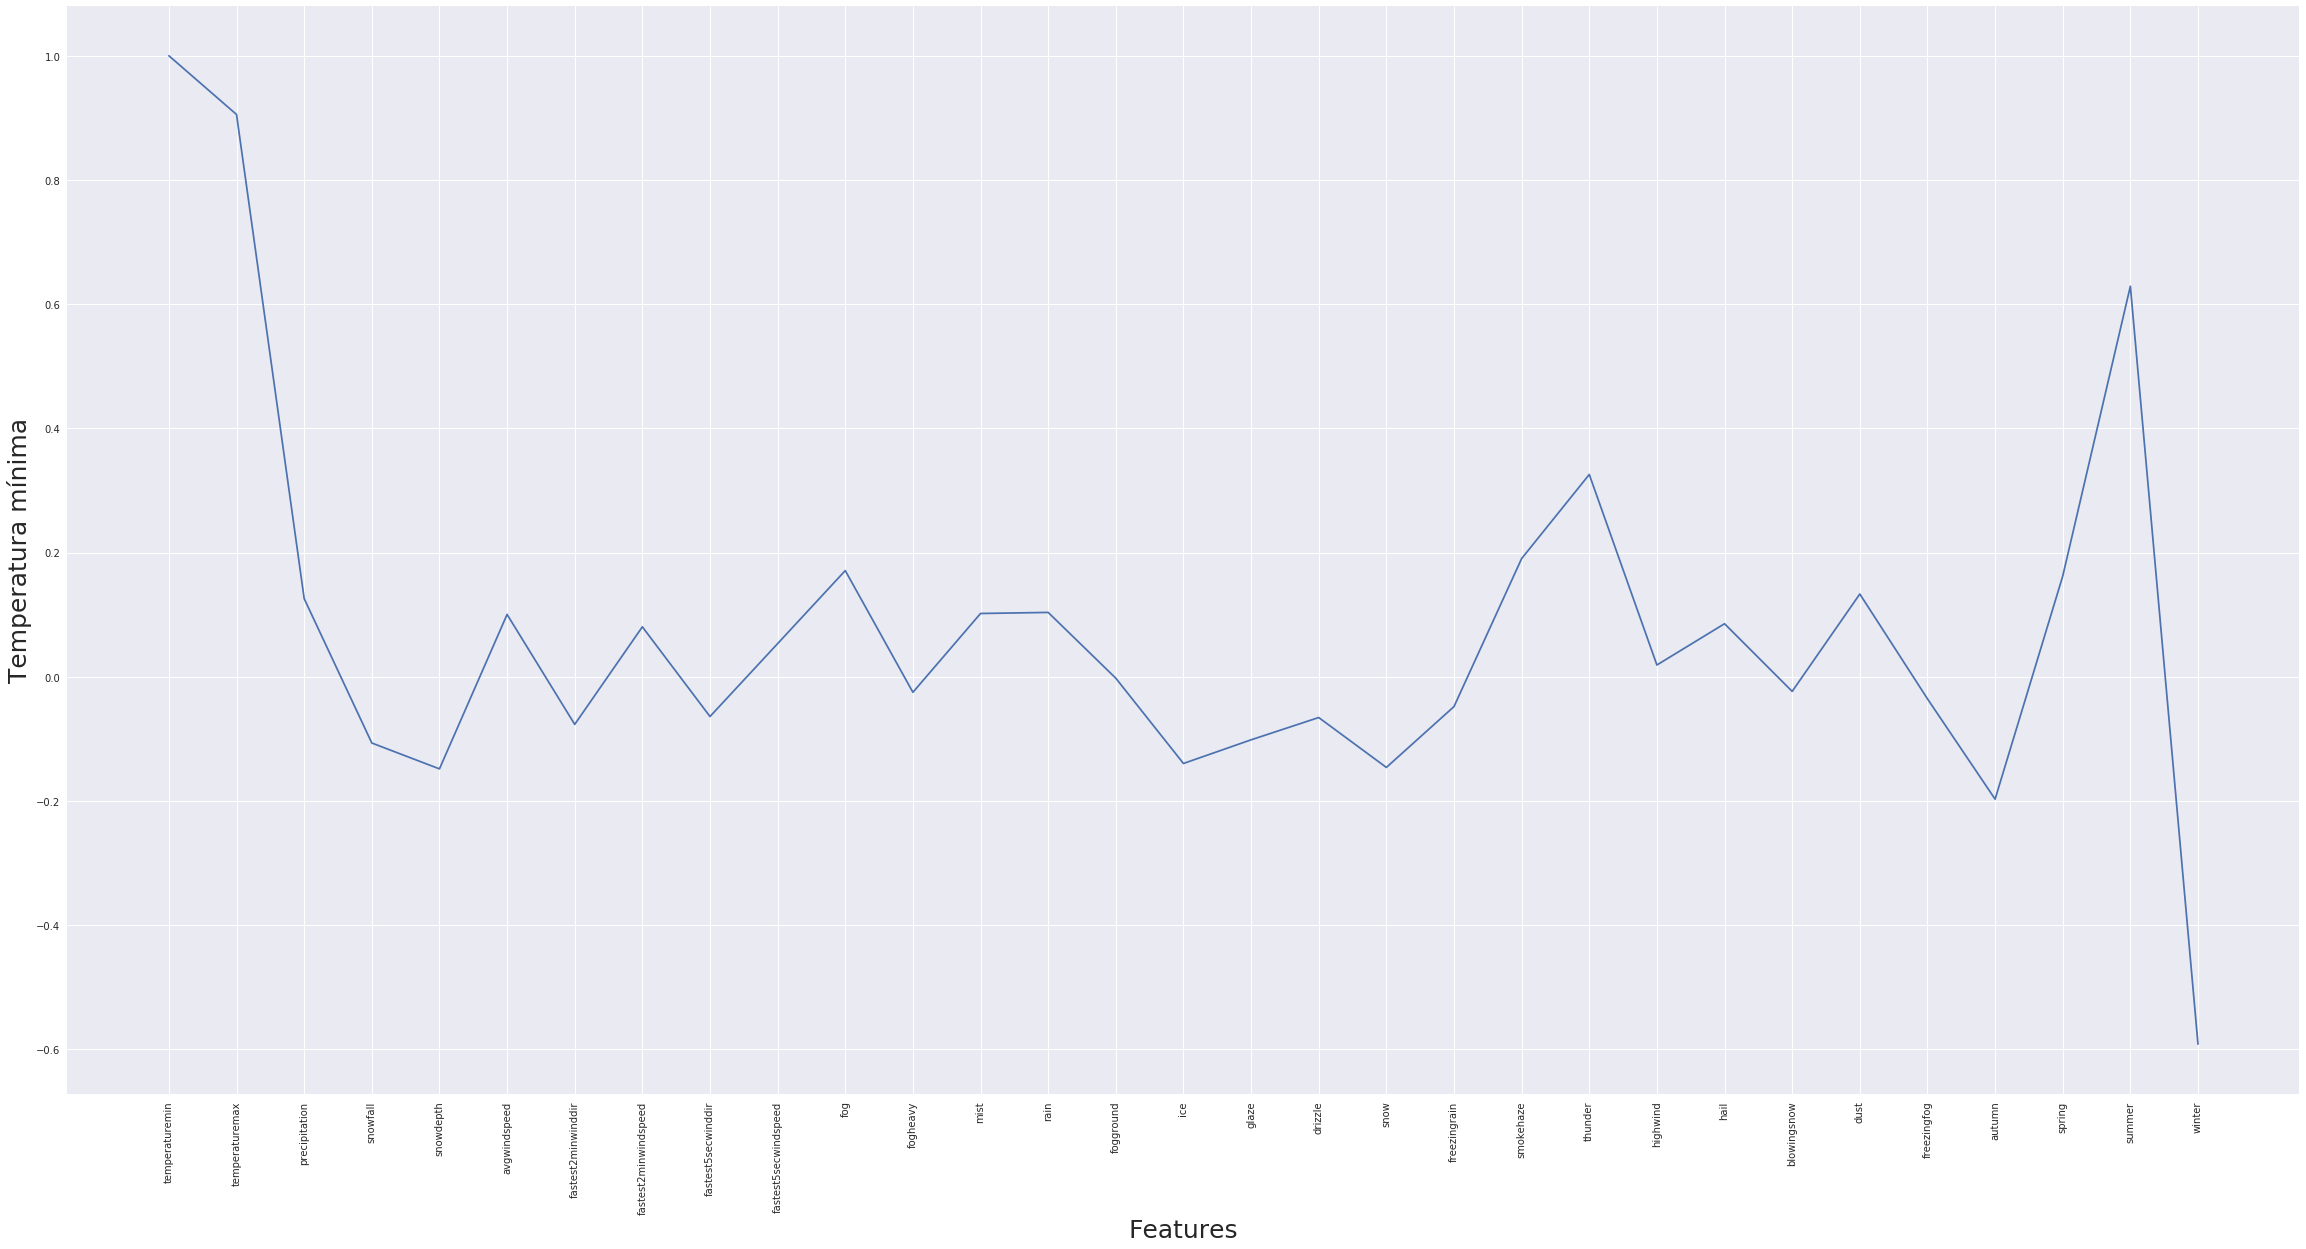

In [61]:
corr_target_features = dummie_weather_history.corr()['temperaturemin']
plt.rcParams['figure.figsize'] = [40, 20]
plt.xticks(rotation='vertical')
plt.plot(corr_target_features)
plt.ylabel('Temperatura mínima', fontsize=25)
plt.xlabel('Features', fontsize=25)
corr_target_features.sort_values(ascending=False)

É perceptível que a *feature* com o coeficiente de correlação mais alto foi o *temperaturemax*, com pouco mais 90%. Com isso, é possível dizer que, na maioria das vezes que a temperatura máxima aumenta, o mesmo acontece com a temperatura mínima. Também é interessante mostrar que *winter* tem uma correlação negativa de cerca de 59%, ou seja, no inverno a tendência da temperatura mínima tende a ser mais baixa.

### 3.2 Comparação dos valores de target com outras features <a name="target-features"></a>
<p>Uma forma de mostrar a forma que os valores de <i>target</i> se comportam em relação a outras <i>features</i> foi desenhar um gráfico onde o eixo <i>y</i> possui os valores de <b>temperatura mínima</b> e o eixo <i>x</i> os valores das outras <i>features</i>. Foram escolhidas 5 <i>features</i> para esse estudo, sendo duas que tiveram os coeficeiente de correlações mais altos positivamente e dois negativamente, além da <i>tunder</i>, escolhido de maneira arbitrária.</p>

<p>Função para facilitar o plot dos gráficos:</p>

In [62]:
y = dummie_weather_history['temperaturemin'].values

def scatter_plotting(column, x_label):
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.scatter(column, y)
    plt.ylabel('Temperatura mínima', fontsize=12)
    plt.xlabel(str(x_label), fontsize=12)

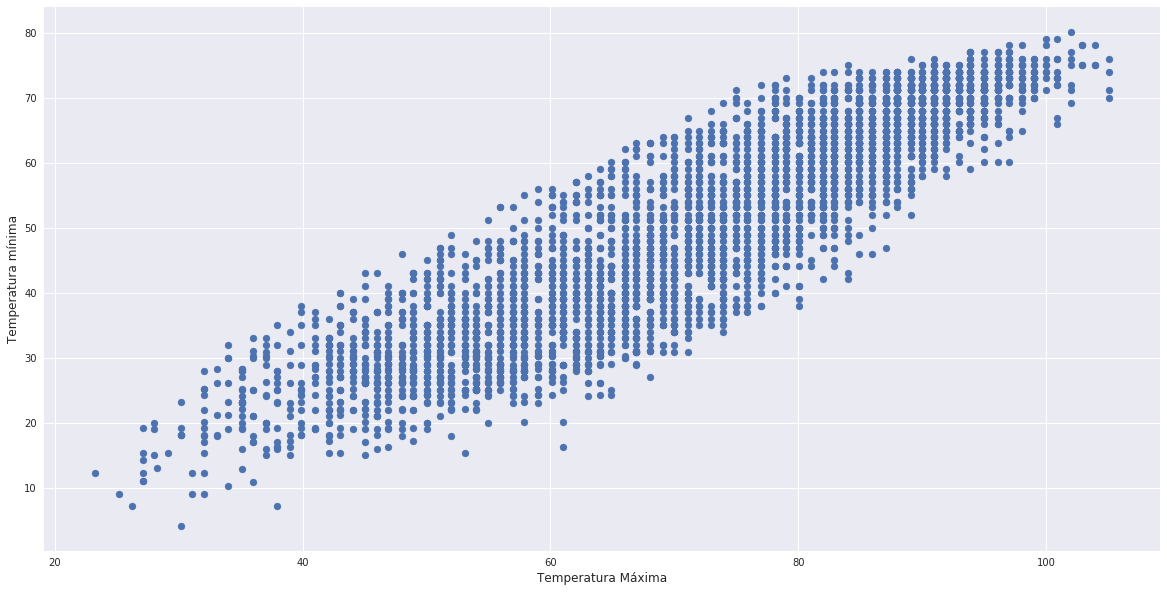

In [63]:
scatter_plotting(dummie_weather_history['temperaturemax'], 'Temperatura Máxima')

Aqui pode-se observar uma relação bem linear entre **temperatura mínima** e **temperatura máxima**, onde a tendência é uma acompanhar o crescimento da outra.

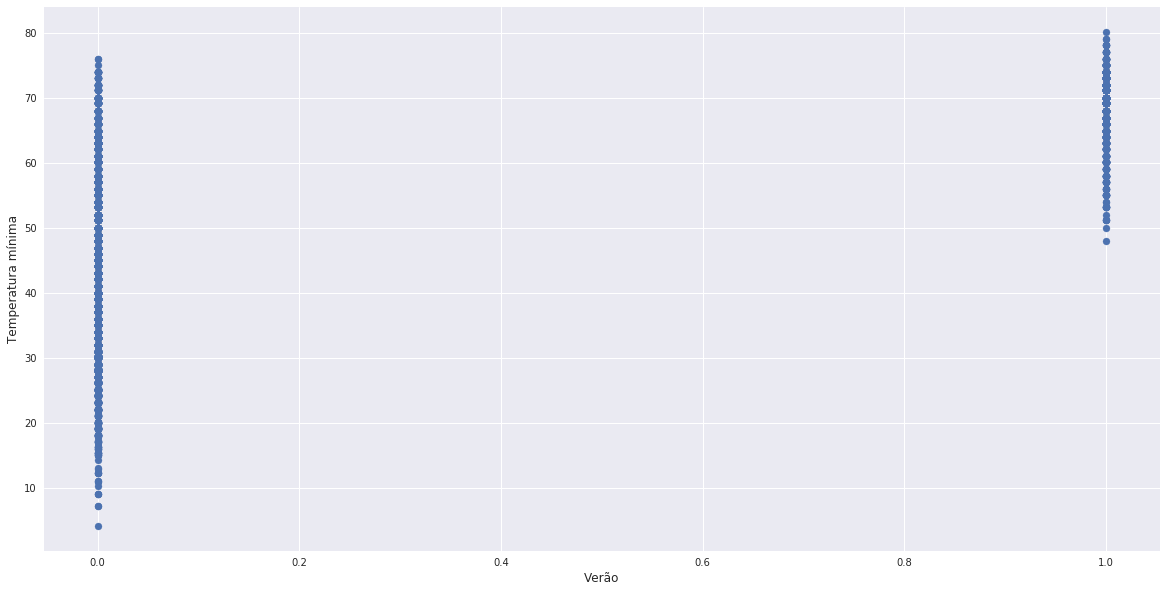

In [64]:
scatter_plotting(dummie_weather_history['summer'], 'Verão')

Quando a **temperatura mínima** é aferida no **verão**, é possível notar que ela não foi menor que pouco menos de 50°F e a maior temperatura mínima também aconteceu no verão. Isso significa que o verão tem uma influência forte na temperatura, o que está de acordo com o mundo real.

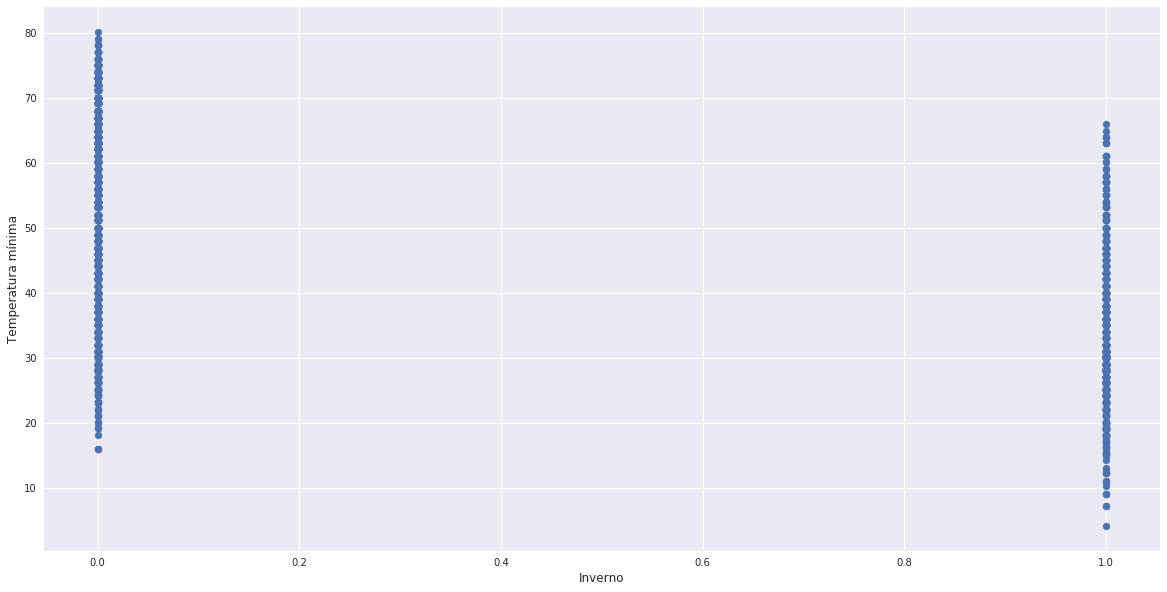

In [65]:
scatter_plotting(dummie_weather_history['winter'], 'Inverno')

O que aconteceu no verão acontece de maneira análoga no **inverno**, ou seja, os menores valores aconteceram nessa estação, além da **temperatura mínima** tender a valores menores.

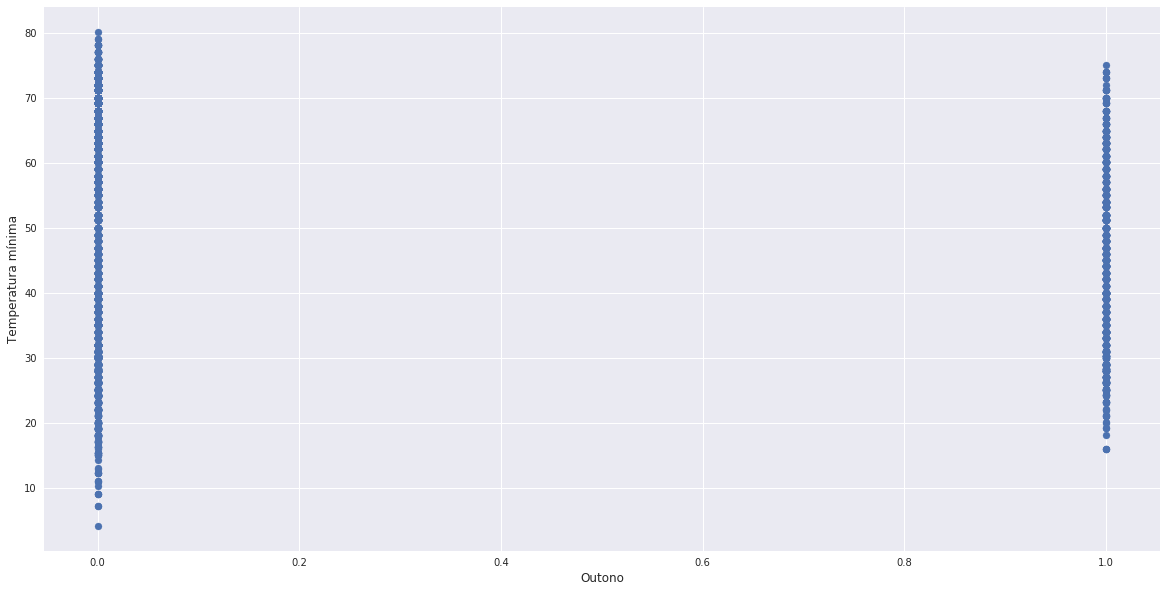

In [66]:
scatter_plotting(dummie_weather_history['autumn'], 'Outono')

No mundo real, o **outono** possui temperaturas mais amenas, por ser uma estação de transição do verão para o inverno. Isso pode ser observado pelos valores da **temperatura mínima** nunca estão nos extremos, se concentrando no meio do eixo *y*.

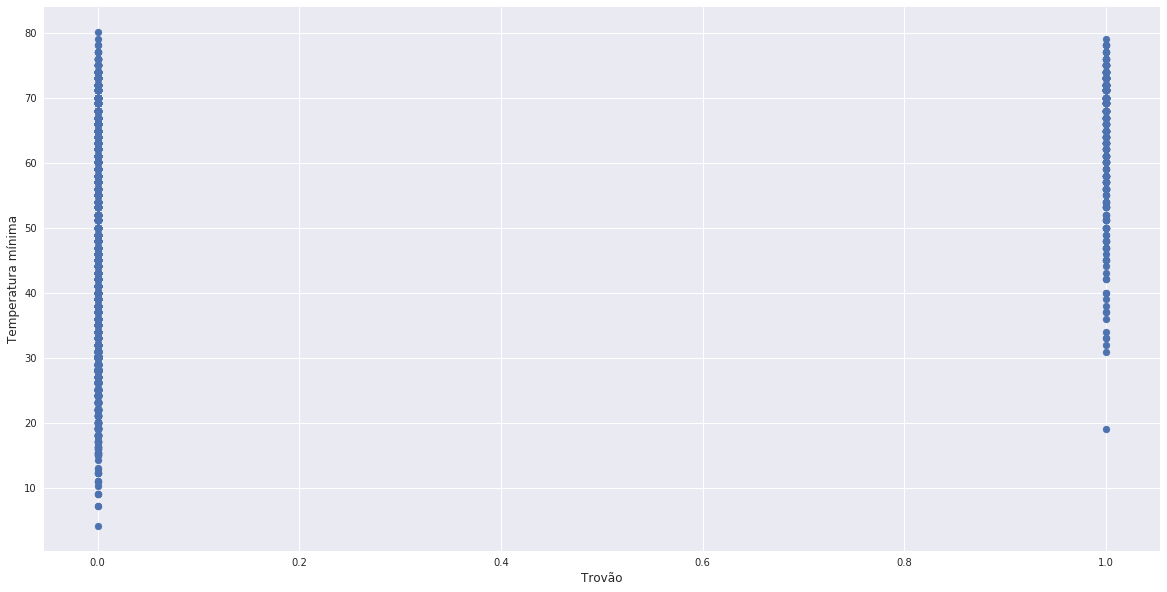

In [67]:
scatter_plotting(dummie_weather_history['thunder'], 'Trovão')

Mesmo tendo uma correlação fraca com a **temperatura mínima**, é interessante observar que a ocorrência de **trovões** ficou a frente de outras *features* que naturalmente deveriam ter correlações maiores com a *target*, como o próprio outono ou chuva.

## 4. Experimentos <a name="experiments"></a>
<p></p>

O método de Gradiente Descendente é um método iterativo de otimização para aprendizado de máquina, sendo recomendado para dados com muitas dimensões. Ele também utiliza regimes de aprendizado online e em lotes, tornando possível sua utilização em bases de dados gigantes, passando dos 50 GB, que não podem ser carregadas diretamente na memória RAM.  

Tomando como exemplo uma regressão linear bastante simples, com somente uma variável dependente e outra independente. A relação entre elas pode ser escrita como `y = u + xw + e` e com isso tentamos achar valores para `û` e `ŵ` que minimizam a soma dos quadrados dos resíduos, ou seja, que minimizam o quadrado da norma do vetor `e`.  

A principal ideia nesses métodos iterativos de otimização é começar com um chute para valores de `û` e `ŵ` e atualizando-os até chegar em um valor mínimo da função custo - `ê`. Essa função custo-especifica da regressão linear é uma função convexa, ou seja, o seu ponto mínimo é global.  

Como é possível vizualizar a função custo como uma tigela, o cálculo de gradiente pode ser usado para alcançar o fundo da tigela, no qual está o ponto de menor custo. Nesse exemplo, onde tem-se apenas as direções no espaço `û` e `ŵ`, para implementar o gradiente descendente, basta atualizar esses valores simultaneamente, subtraindo deles as respectivas derivadas parciais da função custo multiplicado por uma taxa de aprendizado.

### 4.1 Sem usar os Hiperparâmetros <a name="without-using-hyperparameters"></a>

Apesar de ser um dos algoritmos mais poderosos, ele só trará resultados satisfatórios usando os hiperparâmetros corretamente, pois, por não serem aprendidos durante o treinamento, eles devem ser ajusatados manualmente. Mesmo possuindo cerca de 13 parâmetros, 3 deles que influenciam diretamente o sucesso ou o fracasso do experimento, que são:  
- Taxa de aprendizado
- Número de iterações de treino
- Valores iniciais de `ŵ`
Como nesse caso a função custo é convexa, não importa muito por onde começar os chutes de `ŵ`, sendo que com os outros dois é possível chegar no mínimo independente do ponto de partida. Nesse primeiro experimento foram usados os valores default do algoritmo.

In [68]:
X = dummie_weather_history.drop('temperaturemin', axis=1)
y = (dummie_weather_history['temperaturemin'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [69]:
def print_metrics(sgd_regressor):
    train_RMSE = np.sqrt(mean_squared_error(y_train, sgd_regressor.predict(X_train)))
    test_RMSE = np.sqrt(mean_squared_error(y_test, sgd_regressor.predict(X_test)))
    print("Training set score: {:.3f}".format(sgd_regressor.score(X_train, y_train)))
    print("Test set score: {:.3f}".format(sgd_regressor.score(X_test, y_test)))
    print('Training RMSE: {:.3f}'.format(train_RMSE))
    print('Test RMSE: {:.3f}'.format(test_RMSE))

In [70]:
def min_temp_disp_plot(X_df, reg_coef, prediction):
    figure, axes = plt.subplots(figsize=(9, 9))
    ax = sns.regplot(x = y_test, y = prediction, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
    ax = ax.set(xlabel='Temperatura mínima atual', 
    ylabel = 'Temperatura mínima prevista')

    plt.figure(figsize=(19,8))
    plt.plot(range(len(X_df.columns)), reg_coef)
    plt.xticks(range(len(X_df.columns)), X_df.columns, rotation='vertical')
    plt.margins(0.01)
    
    plt.xlabel('Features')
    plt.ylabel('Coeficientes')
    plt.title('SGDRegressor')
    plt.show()

In [71]:
sgd_without_hyper = SGDRegressor(max_iter=5, tol=None)
sgd_without_hyper.fit(X_train, y_train)
sgd_without_hyper_coef = sgd_without_hyper.coef_
predict_without_hyper = sgd_without_hyper.predict(X_test)

In [72]:
print_metrics(sgd_without_hyper)

Training set score: -11358194894348774870614016.000
Test set score: -11422604521399087578218496.000
Training RMSE: 54906599380414.797
Test RMSE: 54304325189958.562


Pode-se observar que o score e o RMSE resultaram em valores absurdamente discrepantes do que é esperado no aprendizado de máquina, sendo inúteis caso fosse ser implementado em uma aplicação real.

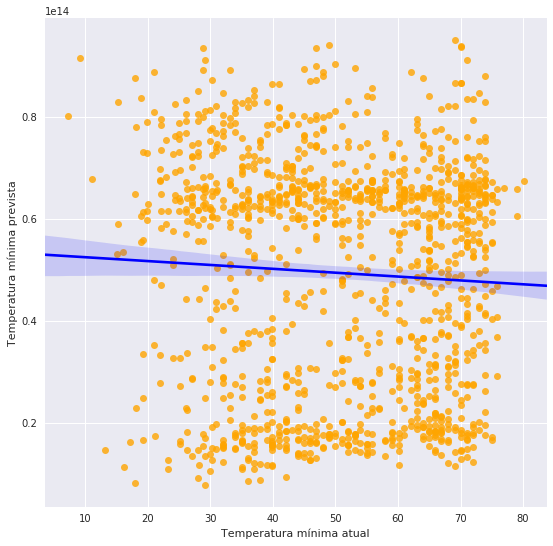

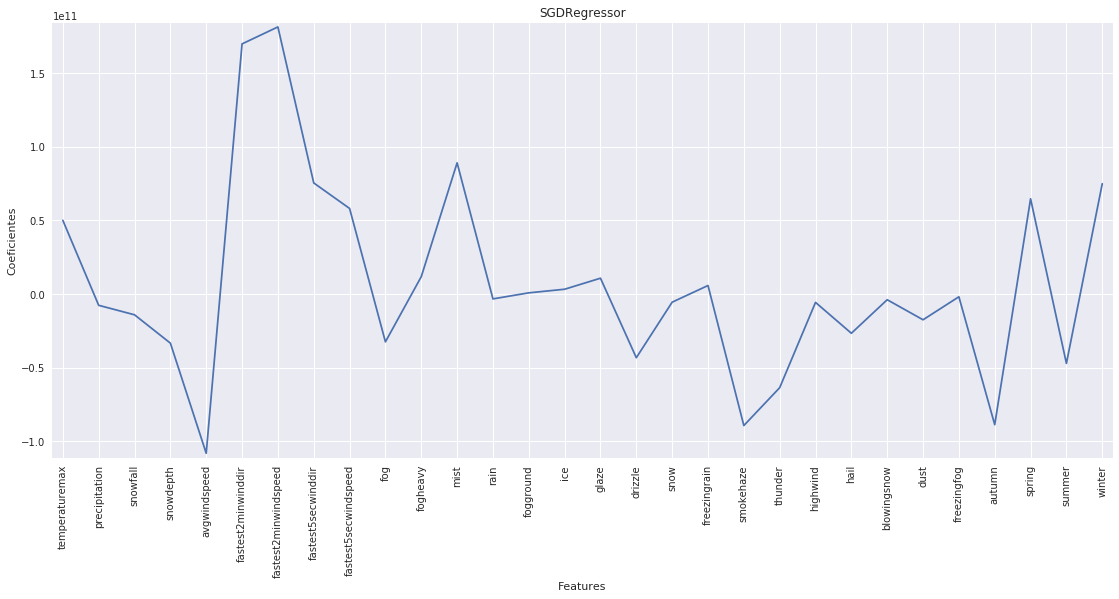

In [73]:
min_temp_disp_plot(X, sgd_without_hyper_coef, predict_without_hyper)

### 4.2 Utilizando os Hiperparâmetros <a name="using-hyperparameters"></a>

A taxa de aprendizado é de extrema importância, pois ele define os tamanhos dos passos que se dá em direção ao mínimo em cada iteração. Se os passos forem muito pequenos, chegaremos ao ponto mínimo em algum momento, porém podem ser necessárias muitas iterações, tornando o algoritmo lento. Caso contrário, pode acontecer de sermos arremessados para cima da função custo, passando do mínimo e com isso, a cada iteração, passamos cada vez mais desse valor.  

Por não poder ser nem tão grande nem tão pequena, é aconselhável testar com valores 1, 0.1, 0.001, 0.0001, 0.00001 e 0.000001. Essa primeira parte testa, usando o score como métrica, alguns valores da taxa de aprendizado inicial.

In [74]:
eta = [10, 1, 0.1, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
scores_eta0 = []

for i in eta:
    sgd_regressor = SGDRegressor(max_iter=5, tol=None, eta0=i)
    sgd_regressor.fit(X_train, y_train)
    scores_eta0.append(sgd_regressor.score(X_test, y_test))

scores_eta0

[-2.4958401896296304e+31,
 -8.493744568438263e+28,
 -2.913789400103901e+27,
 -2327807042227296.5,
 0.8075075950110713,
 0.7709357809344762,
 -0.9918855128744374,
 -2.397660146351432]

Nesse caso, o maior score obtido foi quando a taxa inicial  de aprendizado foi de 0.00001.

In [75]:
sgd_eta0 = SGDRegressor(max_iter=5, tol=None, eta0=0.00001)
sgd_eta0.fit(X_train, y_train)
sgd_eta0_coef = sgd_eta0.coef_
sgd_eta0_predict = sgd_eta0.predict(X_test)

In [76]:
print_metrics(sgd_eta0)

Training set score: 0.818
Test set score: 0.808
Training RMSE: 6.955
Test RMSE: 7.047


Somente ajustando esse hiperparâmetro, houve uma melhora extraordinária nos resultados obtidos, sendo eles relativamente bons.

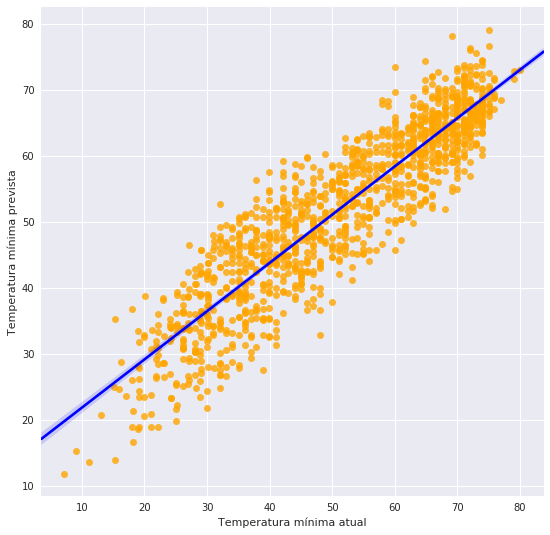

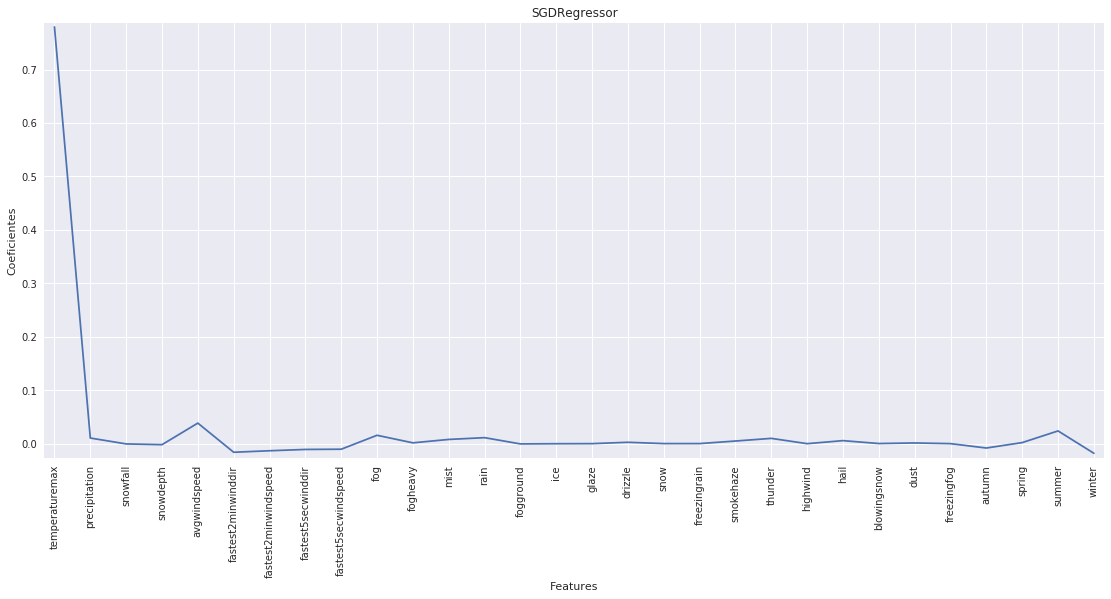

In [77]:
min_temp_disp_plot(X, sgd_eta0_coef, sgd_eta0_predict)

Outro hiperparâmetro bastante relevante é o do número de iterações. Nesse caso, também usando o score como métrica, foram testados alguns valores do máximo de iterações a serem realizadas.

In [78]:
max_iter = [5, 10, 50, 100, 500, 1000]
scores_max_iter = []

for i in max_iter:
    sgd_regressor = SGDRegressor(max_iter=i, tol=None)
    sgd_regressor.fit(X_train, y_train)
    scores_max_iter.append(sgd_regressor.score(X_test, y_test))

scores_max_iter

[-7.206972110673483e+23,
 -1.6220652024705806e+25,
 -5.373272878448725e+23,
 -3.850242913040279e+22,
 -2.199151692608971e+22,
 -1.800004523186742e+24]

Os resultados não foram muito significativos devido a cada vez que essa parte do código era executada, esses resultados flutuaram bastante, o que não levou a uma conclusão sólida. Isso pode ter acontecido devido ao algoritmo convergir para o mínimo com poucas iterações.

Mesmo não sendo tão relevante, também foi interessante tentar modificar a penalidade que o algoritmo iria usar.

In [79]:
penalty = ['l1', 'l2', 'elasticnet']
scores_penalty = []

for i in penalty:
    sgd_regressor = SGDRegressor(max_iter=5, tol=None, penalty=i)
    sgd_regressor.fit(X_train, y_train)
    scores_penalty.append(sgd_regressor.score(X_test, y_test))

scores_penalty

[-3.29688667993626e+25, -1.6385535412504967e+24, -1.1234931497415201e+24]

Como os valores também variaram bastante em cada execução, não foi possível concluir algo com isso. Pode ter acontecido devido a uma das features ser muito mais relevante que as outras.

### 4.3 Utilizando somente a temperatura máxima <a name="using-just-max-temp"></a>  
Com os outros experimentos, foi observado que a feature de maior correlação com a target era a de temperatura máxima, por isso seria interessante realizar um experimento utilizando somente ela para prever a temperatura mínima. O hiperparametro de taxa de aprendizado inicial foi modificado, utilizando o que teve melhor resultado anteriormente.

In [80]:
X_temp_max = dummie_weather_history[['temperaturemax']]
y = (dummie_weather_history['temperaturemin'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [81]:
sgd_temp_max = SGDRegressor(max_iter=5, tol=None, eta0=0.00001)
sgd_temp_max.fit(X_train, y_train)
sgd_temp_max_coef = sgd_temp_max.coef_
predict_just_temp_max = sgd_temp_max.predict(X_test)
X_temp_max.columns

Index(['temperaturemax'], dtype='object')

In [82]:
print_metrics(sgd_temp_max)

Training set score: 0.815
Test set score: 0.803
Training RMSE: 7.015
Test RMSE: 7.126


O resultado foi bem parecido comparado com o uso de todas as features.

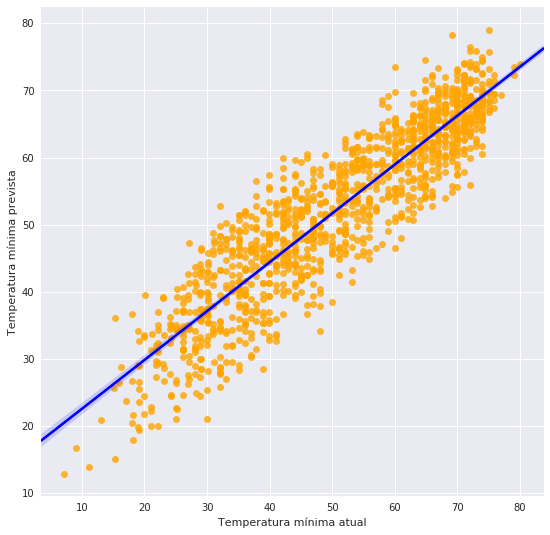

In [83]:
figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predict_just_temp_max, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Temperatura mínima atual', 
ylabel = 'Temperatura mínima prevista')

plt.show()

## 5. Referências  <a name="references"></a>  

> [Gradiente Descendente - Um método poderoso e flexível para otimização iterativa](https://matheusfacure.github.io/2017/02/20/MQO-Gradiente-Descendente/)